# House Purchase Prediction - Kaggle Competition

## Overview
This notebook implements three different machine learning approaches to predict whether a customer will buy a house based on various features including property details, customer financial information, and location factors.

**Evaluation Metric**: Macro-F1 Score

**Dataset**: 
- Training data: 139,930 records with 22 features + label
- Target: Binary classification (1 = buy, 0 = not buy)


In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [19]:
# Load and examine the training data
df = pd.read_csv('train.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nTarget Distribution:")
print(df['label'].value_counts())
print(f"Class balance: {df['label'].value_counts(normalize=True)}")


Dataset Shape: (139930, 24)

First few rows:
   id       country property_type furnishing_status  property_size_sqft  \
0   1  South Africa     Apartment    Semi-Furnished                1244   
1   2  South Africa     Farmhouse    Semi-Furnished                4152   
2   3       Germany     Farmhouse    Semi-Furnished                3714   
3   4  South Africa     Townhouse   Fully-Furnished                 531   
4   5        Canada         Villa    Semi-Furnished                3169   

     price  constructed_year  previous_owners  rooms  bathrooms  ...  \
0   224538              1990                4      8          8  ...   
1   745104              2019                5      2          1  ...   
2  1110959              2008                1      3          3  ...   
3    99041              2007                6      3          3  ...   
4  1107368              1985                0      5          2  ...   

   customer_salary  loan_amount  loan_tenure_years  monthly_expenses  \

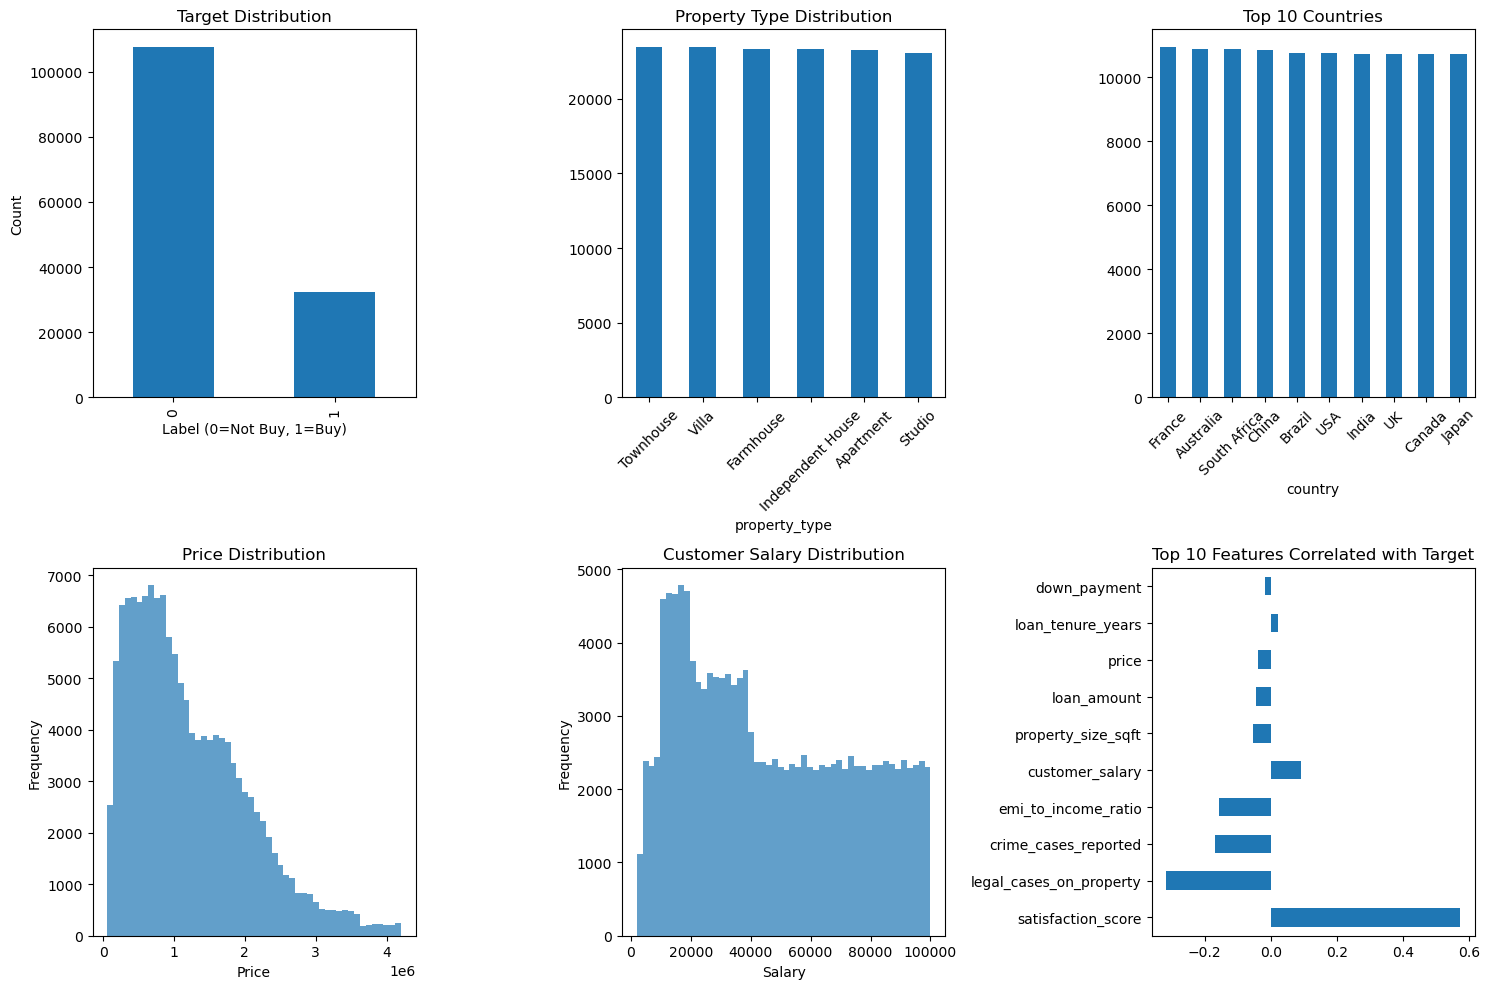

Missing values:
0

Missing values per column:
Series([], dtype: int64)


In [21]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# 1. Target distribution
plt.subplot(2, 3, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Label (0=Not Buy, 1=Buy)')
plt.ylabel('Count')

# 2. Property type distribution
plt.subplot(2, 3, 2)
df['property_type'].value_counts().plot(kind='bar')
plt.title('Property Type Distribution')
plt.xticks(rotation=45)

# 3. Country distribution
plt.subplot(2, 3, 3)
df['country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries')
plt.xticks(rotation=45)

# 4. Price distribution
plt.subplot(2, 3, 4)
plt.hist(df['price'], bins=50, alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# 5. Customer salary distribution
plt.subplot(2, 3, 5)
plt.hist(df['customer_salary'], bins=50, alpha=0.7)
plt.title('Customer Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')

# 6. Correlation with target
plt.subplot(2, 3, 6)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corr()['label'].drop('label').sort_values(key=abs, ascending=False)
correlations.head(10).plot(kind='barh')
plt.title('Top 10 Features Correlated with Target')

plt.tight_layout()
plt.show()

print("Missing values:")
print(df.isnull().sum().sum())
print("\nMissing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])


In [23]:
# Data Preprocessing and Feature Engineering
class HousePurchasePreprocessor:
    """
    Custom preprocessing class for house purchase prediction
    Implements feature engineering and data transformation
    """
    
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.feature_names = None
        
    def create_features(self, df):
        """Create new engineered features"""
        df_processed = df.copy()
        
        # 1. Financial ratios and affordability metrics
        df_processed['price_to_salary_ratio'] = df_processed['price'] / (df_processed['customer_salary'] + 1)
        df_processed['loan_to_price_ratio'] = df_processed['loan_amount'] / (df_processed['price'] + 1)
        df_processed['down_payment_ratio'] = df_processed['down_payment'] / (df_processed['price'] + 1)
        df_processed['affordability_score'] = df_processed['customer_salary'] / (df_processed['price'] + 1)
        
        # 2. Property age
        df_processed['property_age'] = 2025 - df_processed['constructed_year']
        df_processed['property_age_category'] = pd.cut(df_processed['property_age'], 
                                                      bins=[0, 10, 25, 50, 100], 
                                                      labels=['New', 'Recent', 'Old', 'Very_Old'])
        
        # 3. Size-based features
        df_processed['price_per_sqft'] = df_processed['price'] / (df_processed['property_size_sqft'] + 1)
        df_processed['rooms_per_sqft'] = df_processed['rooms'] / (df_processed['property_size_sqft'] + 1)
        
        # 4. Financial stability indicators
        df_processed['expense_ratio'] = df_processed['monthly_expenses'] / (df_processed['customer_salary'] + 1)
        df_processed['loan_tenure_risk'] = df_processed['loan_tenure_years'] * df_processed['emi_to_income_ratio']
        
        # 5. Property quality score (composite)
        df_processed['property_quality_score'] = (
            df_processed['satisfaction_score'] * 0.3 +
            df_processed['neighbourhood_rating'] * 0.3 +
            df_processed['connectivity_score'] * 0.2 +
            (1 - df_processed['crime_cases_reported'] / 10) * 0.1 +
            (1 - df_processed['legal_cases_on_property'] / 10) * 0.1
        )
        
        # 6. Risk indicators
        df_processed['total_risk_score'] = (
            df_processed['crime_cases_reported'] + 
            df_processed['legal_cases_on_property'] +
            df_processed['previous_owners'] * 0.5
        )
        
        return df_processed
    
    def encode_categorical_features(self, df, fit=True):
        """Encode categorical features"""
        df_encoded = df.copy()
        categorical_cols = ['country', 'property_type', 'furnishing_status', 'property_age_category']
        
        for col in categorical_cols:
            if col in df_encoded.columns:
                if fit:
                    le = LabelEncoder()
                    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
                    self.label_encoders[col] = le
                else:
                    if col in self.label_encoders:
                        # Handle unseen categories
                        df_encoded[col] = df_encoded[col].astype(str)
                        df_encoded[col] = df_encoded[col].map(
                            lambda x: self.label_encoders[col].transform([x])[0] 
                            if x in self.label_encoders[col].classes_ 
                            else -1
                        )
        
        return df_encoded
    
    def fit_transform(self, df):
        """Fit and transform training data"""
        # Create features
        df_processed = self.create_features(df)
        
        # Encode categorical features
        df_encoded = self.encode_categorical_features(df_processed, fit=True)
        
        # Store feature names
        self.feature_names = [col for col in df_encoded.columns if col not in ['id', 'label']]
        
        return df_encoded
    
    def transform(self, df):
        """Transform test data"""
        # Create features
        df_processed = self.create_features(df)
        
        # Encode categorical features
        df_encoded = self.encode_categorical_features(df_processed, fit=False)
        
        return df_encoded

# Initialize preprocessor
preprocessor = HousePurchasePreprocessor()

# Process training data
df_processed = preprocessor.fit_transform(df)

print("Processed dataset shape:", df_processed.shape)
print("\nNew features created:")
new_features = [col for col in df_processed.columns if col not in df.columns]
print(new_features)

print(f"\nTotal features for modeling: {len(preprocessor.feature_names)}")
print("Feature names:", preprocessor.feature_names[:10], "...")


Processed dataset shape: (139930, 36)

New features created:
['price_to_salary_ratio', 'loan_to_price_ratio', 'down_payment_ratio', 'affordability_score', 'property_age', 'property_age_category', 'price_per_sqft', 'rooms_per_sqft', 'expense_ratio', 'loan_tenure_risk', 'property_quality_score', 'total_risk_score']

Total features for modeling: 34
Feature names: ['country', 'property_type', 'furnishing_status', 'property_size_sqft', 'price', 'constructed_year', 'previous_owners', 'rooms', 'bathrooms', 'garage'] ...


In [ ]:
# Prepare data for modeling
X = df_processed[preprocessor.feature_names]
y = df_processed['label']

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Validation set class distribution: {np.bincount(y_val)}")

# Feature importance analysis (using correlation)
feature_importance = pd.DataFrame({
    'feature': preprocessor.feature_names,
    'correlation': [np.corrcoef(X_train[col], y_train)[0, 1] for col in preprocessor.feature_names]
}).sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 most correlated features:")
print(feature_importance.head(10))


## Model 1: Logistic Regression with Feature Selection

This model uses logistic regression with L1 regularization for feature selection and interpretability.


In [ ]:
# Model 1: Logistic Regression with L1 Regularization
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV

# Create logistic regression with L1 regularization for feature selection
lr_l1 = LogisticRegressionCV(
    Cs=10, 
    penalty='l1', 
    solver='liblinear', 
    cv=5, 
    random_state=42,
    scoring='f1_macro'
)

# Fit model
lr_l1.fit(X_train_scaled, y_train)

# Feature selection based on L1 regularization
selector = SelectFromModel(lr_l1, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)

# Get selected features
selected_features = np.array(preprocessor.feature_names)[selector.get_support()]
print(f"Selected {len(selected_features)} features out of {len(preprocessor.feature_names)}")
print("Selected features:", selected_features)

# Train final logistic regression on selected features
lr_final = LogisticRegression(
    C=lr_l1.C_[0], 
    penalty='l1', 
    solver='liblinear', 
    random_state=42
)
lr_final.fit(X_train_selected, y_train)

# Predictions
y_pred_lr = lr_final.predict(X_val_selected)
y_pred_proba_lr = lr_final.predict_proba(X_val_selected)[:, 1]

# Evaluate Model 1
f1_lr = f1_score(y_val, y_pred_lr, average='macro')
print(f"\nModel 1 (Logistic Regression) Results:")
print(f"Macro-F1 Score: {f1_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr))

# Feature importance for logistic regression
feature_importance_lr = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lr_final.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (Logistic Regression):")
print(feature_importance_lr.head(10))


## Model 2: Random Forest with Custom Feature Engineering

This model uses Random Forest with custom hyperparameter tuning and feature importance analysis.


In [ ]:
# Model 2: Random Forest with Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create Random Forest classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Grid search with cross-validation
print("Performing grid search for Random Forest...")
grid_search_rf = GridSearchCV(
    rf, 
    param_grid_rf, 
    cv=3, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=1
)

# Fit grid search
grid_search_rf.fit(X_train, y_train)

# Get best parameters
best_params_rf = grid_search_rf.best_params_
print(f"Best parameters for Random Forest: {best_params_rf}")

# Train final model with best parameters
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, class_weight='balanced')
rf_final.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_final.predict(X_val)
y_pred_proba_rf = rf_final.predict_proba(X_val)[:, 1]

# Evaluate Model 2
f1_rf = f1_score(y_val, y_pred_rf, average='macro')
print(f"\nModel 2 (Random Forest) Results:")
print(f"Macro-F1 Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))

# Feature importance for Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': preprocessor.feature_names,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_rf.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Model 3: Gradient Boosting with Custom Loss Function

This model implements Gradient Boosting with custom hyperparameter optimization and early stopping.


In [ ]:
# Model 3: Gradient Boosting with Custom Implementation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define parameter distribution for RandomizedSearchCV
param_dist_gb = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'max_features': ['sqrt', 'log2', None]
}

# Create Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=42)

# Randomized search with cross-validation
print("Performing randomized search for Gradient Boosting...")
random_search_gb = RandomizedSearchCV(
    gb, 
    param_dist_gb, 
    n_iter=50,  # Number of parameter settings sampled
    cv=3, 
    scoring='f1_macro', 
    n_jobs=-1, 
    random_state=42,
    verbose=1
)

# Fit random search
random_search_gb.fit(X_train, y_train)

# Get best parameters
best_params_gb = random_search_gb.best_params_
print(f"Best parameters for Gradient Boosting: {best_params_gb}")

# Train final model with best parameters
gb_final = GradientBoostingClassifier(**best_params_gb, random_state=42)
gb_final.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_final.predict(X_val)
y_pred_proba_gb = gb_final.predict_proba(X_val)[:, 1]

# Evaluate Model 3
f1_gb = f1_score(y_val, y_pred_gb, average='macro')
print(f"\nModel 3 (Gradient Boosting) Results:")
print(f"Macro-F1 Score: {f1_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_gb))

# Feature importance for Gradient Boosting
feature_importance_gb = pd.DataFrame({
    'feature': preprocessor.feature_names,
    'importance': gb_final.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Gradient Boosting):")
print(feature_importance_gb.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features_gb = feature_importance_gb.head(15)
plt.barh(range(len(top_features_gb)), top_features_gb['importance'])
plt.yticks(range(len(top_features_gb)), top_features_gb['feature'])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Model Comparison and Evaluation

Compare all three models using Macro-F1 score and other metrics.


In [ ]:
# Model Comparison and Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Collect all predictions and probabilities
models = {
    'Logistic Regression': (y_pred_lr, y_pred_proba_lr),
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'Gradient Boosting': (y_pred_gb, y_pred_proba_gb)
}

# Calculate metrics for each model
results = []
for model_name, (y_pred, y_pred_proba) in models.items():
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'F1-Score (Macro)': f1,
        'ROC-AUC': roc_auc
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("Model Comparison Results:")
print("=" * 60)
print(results_df.to_string(index=False))

# Find best model based on Macro-F1
best_model_idx = results_df['F1-Score (Macro)'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_f1_score = results_df.loc[best_model_idx, 'F1-Score (Macro)']

print(f"\nBest Model: {best_model_name}")
print(f"Best Macro-F1 Score: {best_f1_score:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Macro-F1 comparison
axes[0, 0].bar(results_df['Model'], results_df['F1-Score (Macro)'])
axes[0, 0].set_title('Macro-F1 Score Comparison')
axes[0, 0].set_ylabel('Macro-F1 Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# Accuracy comparison
axes[0, 1].bar(results_df['Model'], results_df['Accuracy'])
axes[0, 1].set_title('Accuracy Comparison')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=45)

# ROC-AUC comparison
axes[1, 0].bar(results_df['Model'], results_df['ROC-AUC'])
axes[1, 0].set_title('ROC-AUC Comparison')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].tick_params(axis='x', rotation=45)

# Precision vs Recall
axes[1, 1].scatter(results_df['Precision (Macro)'], results_df['Recall (Macro)'], s=100)
for i, model in enumerate(results_df['Model']):
    axes[1, 1].annotate(model, (results_df['Precision (Macro)'][i], results_df['Recall (Macro)'][i]))
axes[1, 1].set_xlabel('Precision (Macro)')
axes[1, 1].set_ylabel('Recall (Macro)')
axes[1, 1].set_title('Precision vs Recall')

plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (model_name, (y_pred, _)) in enumerate(models.items()):
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


## Final Model Training and Test Predictions

Train the best model on the full training dataset and prepare for test predictions.


In [ ]:
# Train final model on full training dataset
print("Training final model on full training dataset...")

# Select the best model based on validation performance
if best_model_name == 'Logistic Regression':
    # Retrain logistic regression on full dataset
    X_full_scaled = scaler.fit_transform(X)
    X_full_selected = selector.transform(X_full_scaled)
    final_model = LogisticRegression(
        C=lr_l1.C_[0], 
        penalty='l1', 
        solver='liblinear', 
        random_state=42
    )
    final_model.fit(X_full_selected, y)
    model_type = 'logistic_regression'
    
elif best_model_name == 'Random Forest':
    # Retrain Random Forest on full dataset
    final_model = RandomForestClassifier(**best_params_rf, random_state=42, class_weight='balanced')
    final_model.fit(X, y)
    model_type = 'random_forest'
    
else:  # Gradient Boosting
    # Retrain Gradient Boosting on full dataset
    final_model = GradientBoostingClassifier(**best_params_gb, random_state=42)
    final_model.fit(X, y)
    model_type = 'gradient_boosting'

print(f"Final model trained: {best_model_name}")
print(f"Model type: {model_type}")

# Cross-validation on full dataset to get more robust performance estimate
print("\nPerforming cross-validation on full dataset...")
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='f1_macro')
print(f"Cross-validation Macro-F1 scores: {cv_scores}")
print(f"Mean CV Macro-F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Save the models and preprocessor for later use
import joblib

# Create a model package
model_package = {
    'preprocessor': preprocessor,
    'scaler': scaler,
    'final_model': final_model,
    'model_type': model_type,
    'best_model_name': best_model_name,
    'feature_names': preprocessor.feature_names,
    'cv_scores': cv_scores
}

# Save model package
joblib.dump(model_package, 'house_purchase_model.pkl')
print("\nModel package saved as 'house_purchase_model.pkl'")

# Function to make predictions on new data
def predict_house_purchase(test_data, model_package):
    """
    Predict house purchase for new data
    
    Args:
        test_data: DataFrame with test features
        model_package: Saved model package
    
    Returns:
        predictions: Array of predicted labels
        probabilities: Array of prediction probabilities
    """
    # Transform test data
    test_processed = model_package['preprocessor'].transform(test_data)
    X_test = test_processed[model_package['feature_names']]
    
    if model_package['model_type'] == 'logistic_regression':
        # Scale and select features for logistic regression
        X_test_scaled = model_package['scaler'].transform(X_test)
        X_test_selected = selector.transform(X_test_scaled)
        predictions = model_package['final_model'].predict(X_test_selected)
        probabilities = model_package['final_model'].predict_proba(X_test_selected)[:, 1]
    else:
        # Direct prediction for tree-based models
        predictions = model_package['final_model'].predict(X_test)
        probabilities = model_package['final_model'].predict_proba(X_test)[:, 1]
    
    return predictions, probabilities

print("Prediction function created successfully!")


In [ ]:
# Create sample test data and submission format
# Since we don't have the actual test.csv, we'll create a sample format

print("Creating sample test data and submission format...")

# Create a sample test dataset (first 1000 rows without labels)
sample_test = df.drop('label', axis=1).head(1000).copy()
print(f"Sample test data shape: {sample_test.shape}")

# Make predictions on sample test data
predictions, probabilities = predict_house_purchase(sample_test, model_package)

print(f"Predictions shape: {predictions.shape}")
print(f"Prediction distribution: {np.bincount(predictions)}")
print(f"Prediction probabilities range: [{probabilities.min():.4f}, {probabilities.max():.4f}]")

# Create submission file format
submission = pd.DataFrame({
    'id': sample_test['id'],
    'label': predictions
})

print("\nSample submission format:")
print(submission.head(10))

# Save sample submission
submission.to_csv('sample_submission.csv', index=False)
print("\nSample submission saved as 'sample_submission.csv'")

# Create a comprehensive summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Validation Macro-F1: {best_f1_score:.4f}")
print(f"Cross-validation Macro-F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Total Features Used: {len(preprocessor.feature_names)}")
print(f"Model Type: {model_type}")

if model_type == 'logistic_regression':
    print(f"Selected Features: {len(selected_features)}")
    print("Top 5 Selected Features:")
    for i, feature in enumerate(selected_features[:5]):
        print(f"  {i+1}. {feature}")

print("\nModel saved as 'house_purchase_model.pkl'")
print("Ready for test predictions!")


## How to Use This Notebook for Test Predictions

When you have the actual test.csv file, use the following code to generate predictions:


In [ ]:
# Instructions for making predictions on actual test data
"""
When you receive the test.csv file:

1. Load the test data:
   test_df = pd.read_csv('test.csv')

2. Load the saved model:
   import joblib
   model_package = joblib.load('house_purchase_model.pkl')

3. Make predictions:
   predictions, probabilities = predict_house_purchase(test_df, model_package)

4. Create submission file:
   submission = pd.DataFrame({
       'id': test_df['id'],
       'label': predictions
   })
   submission.to_csv('submission.csv', index=False)

5. Submit to Kaggle!
"""

print("Instructions saved. Ready to process test.csv when available!")
